In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import time

import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from collections import Counter

from PIL import Image
from torchvision import datasets
import cv2
from sklearn.manifold import TSNE

## Load Dataset using ImageFolder

In [2]:
dataset = datasets.ImageFolder('../datasets/train_data')

class_names = dataset.classes
num_classes = len(class_names)

total_images = len(dataset)

print(f'Total images: {total_images}')
print(f'Number of classes: {num_classes}')
print(f'Class names: {class_names}')

Total images: 4485
Number of classes: 3
Class names: ['cherry', 'strawberry', 'tomato']


# Visualise Class Distributions

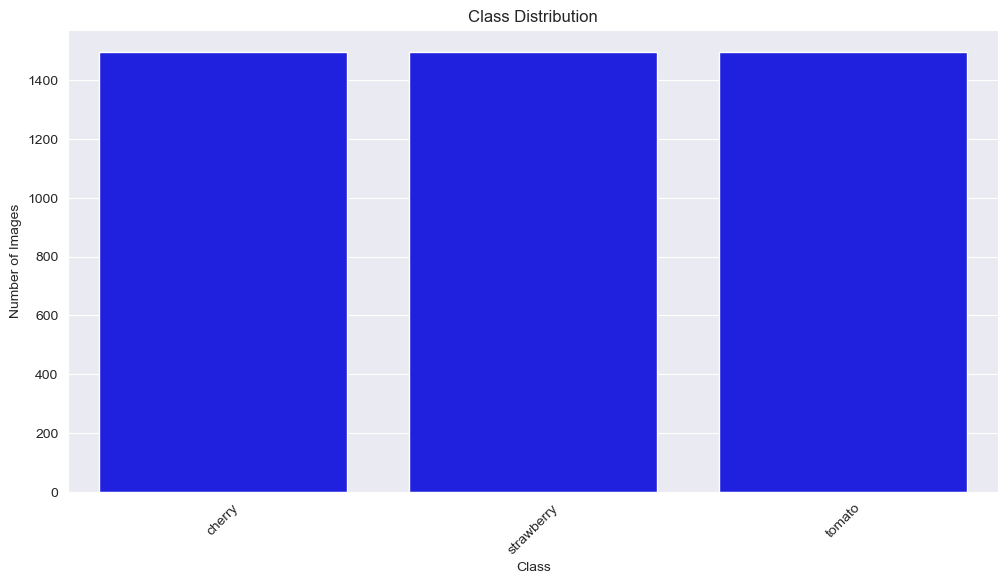

Percentage of images per class:
Class
cherry        33.333333
strawberry    33.333333
tomato        33.333333
Name: proportion, dtype: float64


In [4]:
class_indices = [s[1] for s in dataset.samples]

df = pd.DataFrame({'Class': [class_names[idx] for idx in class_indices]})

plt.figure(figsize=(12, 6))
sns.countplot(x='Class', data=df, color='blue')
plt.xticks(rotation=45)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

class_counts = df['Class'].value_counts(normalize=True) * 100
print("Percentage of images per class:")
print(class_counts)

view numbers of class counts

In [5]:
class_counts = Counter([label for _, label in dataset])
print(class_counts)

Counter({0: 1495, 1: 1495, 2: 1495})


# Helper function for visualising a set of images

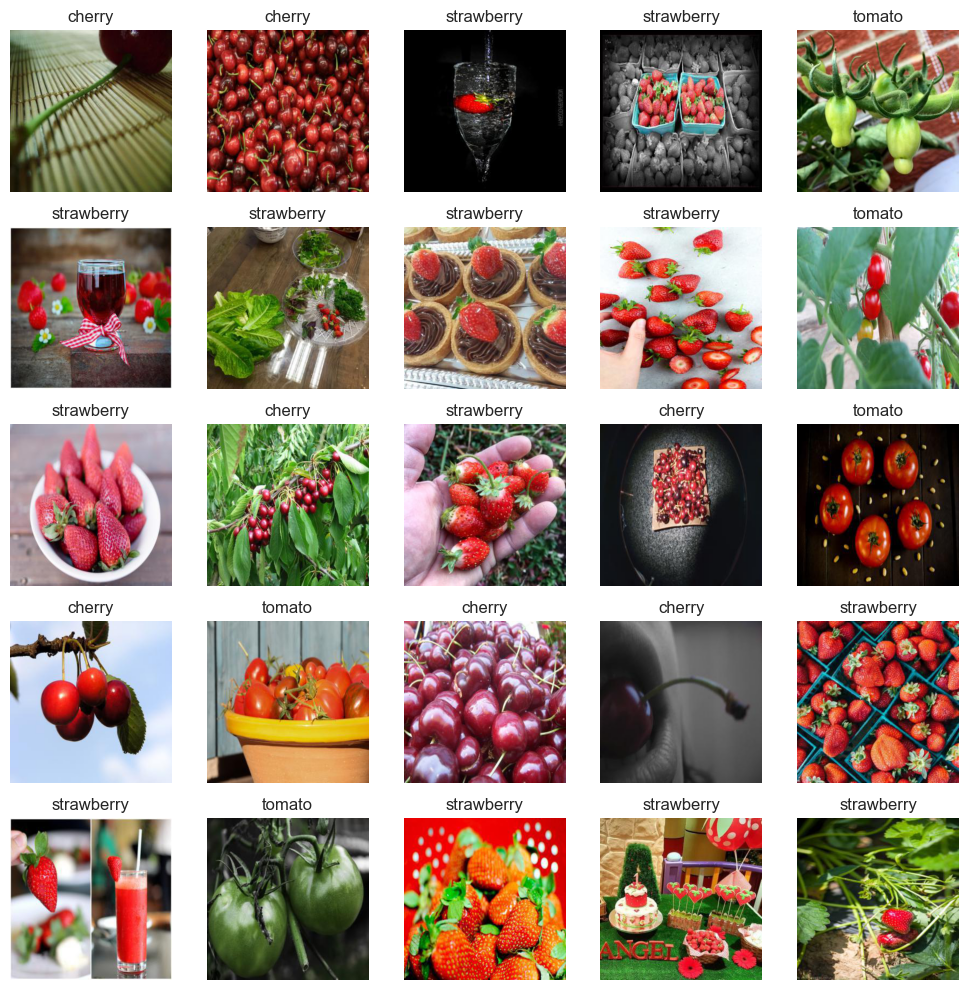

In [6]:
def show_samples(dataset, class_names, num_images=25):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(dataset), num_images, replace=False)
    for i, idx in enumerate(indices):
        img_path, label = dataset.samples[idx]
        with Image.open(img_path) as img:
            img = img.convert("RGB") 
            plt.subplot(5, 5, i+1)
            plt.imshow(img)
            plt.title(class_names[label])
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(dataset, class_names)

# View Statistics on image sizes

Image Size Statistics:
             Width       Height  Aspect_Ratio
count  4485.000000  4485.000000   4485.000000
mean    299.537347   299.332441      1.001692
std      13.674395    16.324167      0.043752
min     178.000000   138.000000      0.628975
25%     300.000000   300.000000      1.000000
50%     300.000000   300.000000      1.000000
75%     300.000000   300.000000      1.000000
max     870.000000   957.000000      2.652174
Number of images not of size 300x300: 53


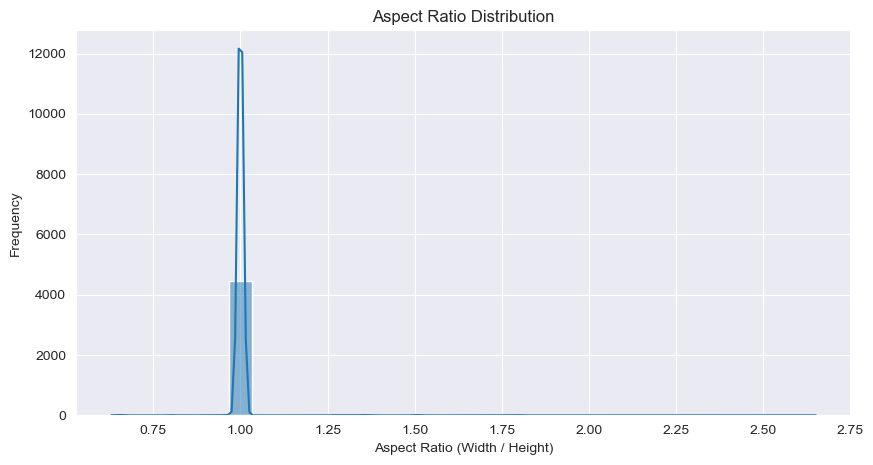

In [7]:
image_sizes = []
for img_path, _ in dataset.samples:
    with Image.open(img_path) as img:
        image_sizes.append(img.size)  

df_sizes = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
df_sizes['Aspect_Ratio'] = df_sizes['Width'] / df_sizes['Height']

print("Image Size Statistics:")
print(df_sizes.describe())

desired_width = 300
desired_height = 300

incorrect_size = df_sizes[
    (df_sizes['Width'] != desired_width) | (df_sizes['Height'] != desired_height)
]

print(f"Number of images not of size {desired_width}x{desired_height}: {len(incorrect_size)}")

plt.figure(figsize=(10, 5))
sns.histplot(df_sizes['Aspect_Ratio'], bins=30, kde=True)
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Frequency')
plt.show()

# Check for greyscale images

In [8]:
def is_grayscale(img_path):
    with Image.open(img_path) as img:
        img_np = np.array(img)
        if len(img_np.shape) == 2:
            return True
        elif len(img_np.shape) == 3:
            if np.all(img_np[:, :, 0] == img_np[:, :, 1]) and np.all(img_np[:, :, 1] == img_np[:, :, 2]):
                return True
        return False

grayscale_count = 0
for img_path, _ in dataset.samples:
    if is_grayscale(img_path):
        grayscale_count += 1

print(f'Grayscale images: {grayscale_count}')
print(f'Percentage of grayscale images: {(grayscale_count / total_images) * 100:.2f}%')

Grayscale images: 8
Percentage of grayscale images: 0.18%


# Check for blurry images

In [9]:
import cv2
def is_blurry(img_path, threshold=100):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return False
    fm = cv2.Laplacian(img, cv2.CV_64F).var()
    return fm < threshold

blurry_images = []
for img_path, _ in dataset.samples:
    if is_blurry(img_path):
        blurry_images.append(img_path)

print(f'Blurry images: {len(blurry_images)}')
print(f'Percentage of blurry images: {(len(blurry_images) / total_images) * 100:.2f}%')

Blurry images: 475
Percentage of blurry images: 10.59%


# Look at noise values

Noise Levels Statistics:
              Noise
count   4485.000000
mean     588.207798
std      703.189271
min        7.062692
25%      183.402144
50%      370.266809
75%      734.800813
max    11369.025794


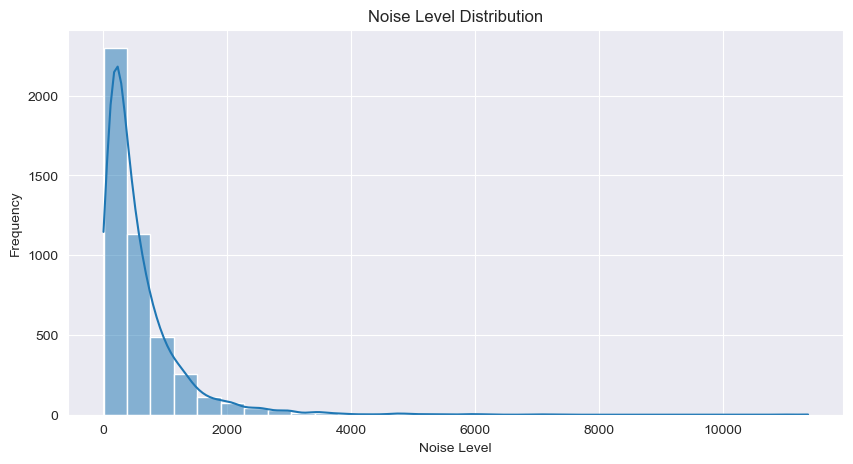

In [10]:
def estimate_noise(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return 0
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    noise = cv2.Laplacian(img_gray, cv2.CV_64F).var()
    return noise

noise_levels = []
for img_path, _ in dataset.samples:
    noise = estimate_noise(img_path)
    noise_levels.append(noise)

df_noise = pd.DataFrame({'Noise': noise_levels})
print("Noise Levels Statistics:")
print(df_noise.describe())

plt.figure(figsize=(10, 5))
sns.histplot(df_noise['Noise'], bins=30, kde=True)
plt.title('Noise Level Distribution')
plt.xlabel('Noise Level')
plt.ylabel('Frequency')
plt.show()

# Image Brightness Distribution

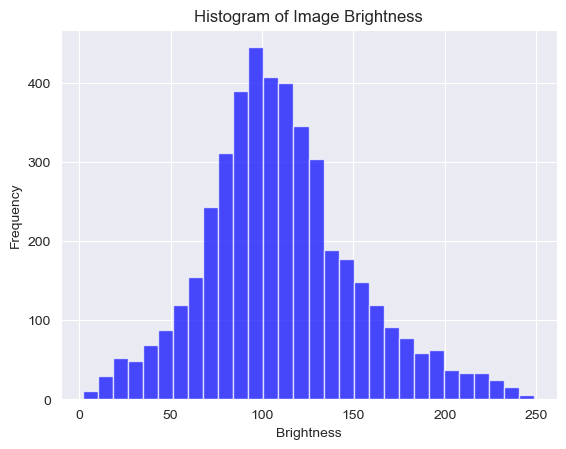

In [11]:
brightness = [np.array(image).mean() for image, _ in dataset]
plt.hist(brightness, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of Image Brightness')
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.show()

# Distribution of color Intensities

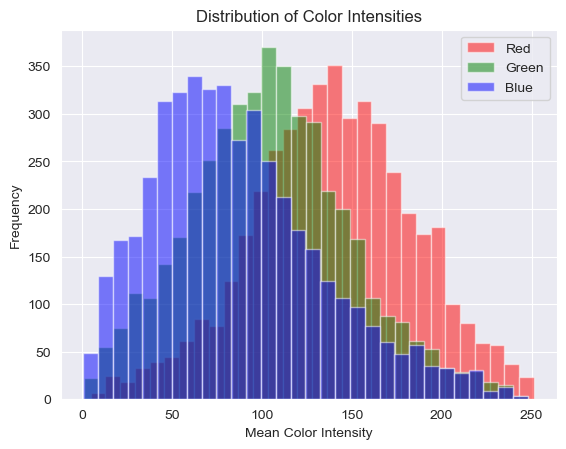

In [12]:
r_values, g_values, b_values = [], [], []

for image, _ in dataset:
    np_image = np.array(image)
    r_values.append(np_image[:, :, 0].mean())  
    g_values.append(np_image[:, :, 1].mean())  
    b_values.append(np_image[:, :, 2].mean())  

plt.hist(r_values, bins=30, alpha=0.5, label='Red', color='r')
plt.hist(g_values, bins=30, alpha=0.5, label='Green', color='g')
plt.hist(b_values, bins=30, alpha=0.5, label='Blue', color='b')
plt.xlabel('Mean Color Intensity')
plt.ylabel('Frequency')
plt.title('Distribution of Color Intensities')
plt.legend()
plt.show()